####################################imort libraries############################################

In [2]:
import pennylane as qml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import imutils
import keras 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report

####################################data preprocessing############################################

In [3]:
# Path to the data directory
data_dir = 'E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set'
# Get the list of all the images
images = os.listdir(data_dir)
# Get the list of all the images
data = []
labels = []
for i in ['Healthy', 'Brain Tumor']:
    path = os.path.join(data_dir,i)
    for img in os.listdir(path):
        try:
            image = cv2.imread(os.path.join(path,img))
            print(os.path.join(path,img))
            image = cv2.resize(image, (224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
# Shuffle the data
data,labels = shuffle(data,labels, random_state=42)
# Split the data into train and test set
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1,random_state=42)
# Normalize the data
train_data = train_data / 255.0
test_data = test_data / 255.0
# Onehot encoding the labels
train_labels = pd.get_dummies(train_labels).values
test_labels = pd.get_dummies(test_labels).values
# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
train_datagen.fit(train_data)

E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1).jpeg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1).png
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (10).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (100).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1000).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1001).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1002).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1003).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1004).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1005).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (1006).jpg
E:\QCNN\Brain Tumor Data Set\Brain Tumo

####################################data visualization############################################

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


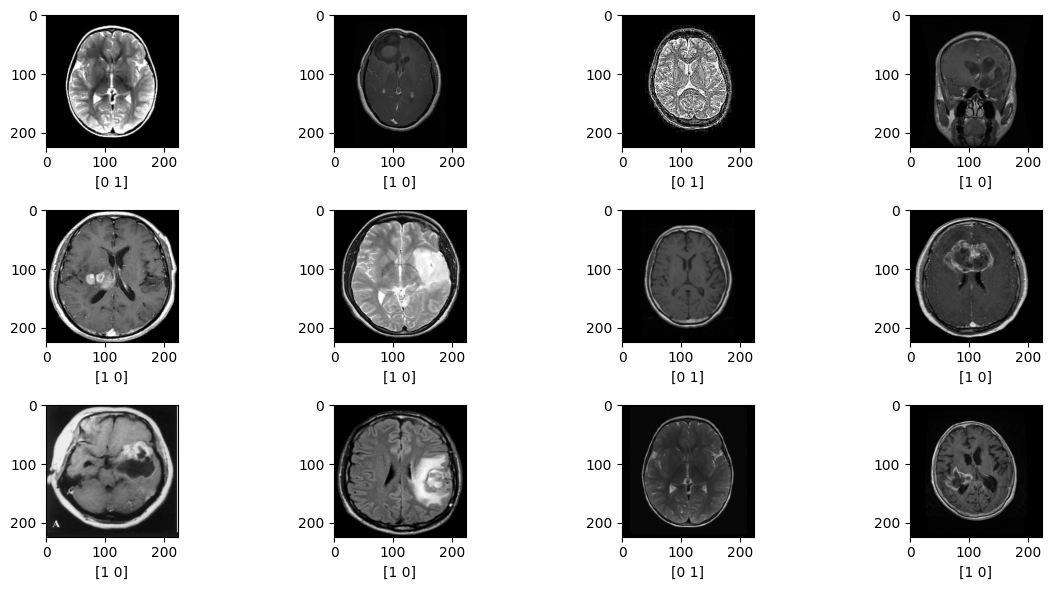

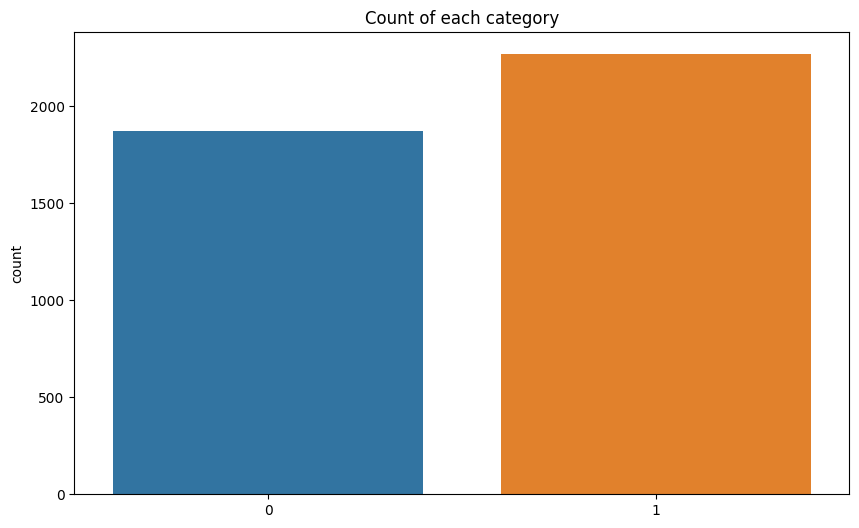

In [4]:
# Plotting the images
plt.figure(0, figsize=(12,6))  # create a new figure with size 12x6
for i in range(1, 13):  # loop over the first 12 images in the dataset
    plt.subplot(3, 4, i)  # create a subplot with 3 rows, 4 columns, and index i
    plt.imshow(train_data[i], cmap='gray')  # plot the i-th image in grayscale
    plt.xlabel(train_labels[i])  # set the x-label to the i-th label in the dataset
plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

# Plotting the count of each category
plt.figure(figsize=(10, 6))  # create a new figure with size 10x6
sns.countplot(x=train_labels[:,0])  # plot a countplot of the first column of the train_labels array
plt.title("Count of each category")  # set the title of the plot
plt.show()  # display the plot

####################################Quantum Model############################################

In [21]:
# Quantum circuit
def circuit(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[2], wires[0]])
    return qml.expval(qml.PauliZ(0))

params = [0.1, 0.2, 0.3]
drawer = qml.draw(circuit)
print(drawer(params, wires=range(3)))

# Quantum device
dev = qml.device("default.qubit", wires=3)

# Quantum node
@qml.qnode(dev)
def quantum_model(params, wires):
    return circuit(params, wires)

# Cost function
def cost(var, features, labels):
    predictions = [quantum_model(var, wires=range(3)) for feature in features]
    return square_loss(labels, predictions)

# Square loss
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

# Gradient descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# Training the quantum model
def training(var, features, labels, steps, shots):
    for i in range(steps):
        var = opt.step(lambda v: cost(v, features, labels), var)
        if (i + 1) % 5 == 0:
            preds = [np.sign(quantum_model(var, wires=range(3))) for feature in features]
            acc = accuracy(labels, preds)
            loss = cost(var, features, labels)
            print("Step {}: Accuracy = {}, Loss = {}".format(i + 1, acc, loss))
    return var

# Accuracy
def accuracy(labels, predictions):
    acc = 1
    for l, p in zip(labels, predictions):
        if np.array_equal(l, p):
            acc = acc + 1
    acc = acc / len(labels)
    return acc

# Initial parameters
np.random.seed(0)
var_init = np.random.randn(18)

# Training the quantum model
var = training(var_init, train_data, train_labels, steps=100, shots=1000)

# Testing the quantum model
preds = [np.sign(quantum_model(var, wires=range(3))) for feature in test_data]
acc = accuracy(test_labels, preds)
loss = cost(var, test_data, test_labels)
print("Accuracy on test data = {}%".format(acc * 100))
print("Loss on test data = {}".format(loss))


0: ──RX(0.10)─╭●────╭X─┤  <Z>
1: ──RY(0.20)─╰X─╭●─│──┤     
2: ──RZ(0.30)────╰X─╰●─┤     
Step 5: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 10: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 15: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 20: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 25: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 30: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 35: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 40: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 45: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 50: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 55: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 60: Accuracy = 0.00024154589371980676, Loss = [0.38717464 0.46730696]
Step 65: Ac

####################################Classical Model############################################

In [22]:
# Building the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=32), epochs=10, validation_data=(test_data, test_labels))

# Evaluating the model
model.evaluate(test_data, test_labels)

# Predicting the model
preds = model.predict(test_data)
preds = np.argmax(preds, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_labels, preds, target_names=['Healthy', 'Brain Tumor']))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 346112)           

####################################Comparing the models############################################

In [ ]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

####################################Saving the models############################################

In [ ]:
# Saving the quantum model
qml.save(var, 'E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Quantum Model')

# Saving the classical model
model.save('E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Classical Model')

####################################Loading the models############################################

In [ ]:
# Loading the quantum model
var = qml.load('E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Quantum Model')

# Loading the classical model
model = load_model('E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set\Classical Model')

####################################Testing the models############################################

In [ ]:
# Testing the quantum model
preds = [np.sign(quantum_model(var, wires=range(3))) for feature in test_data]
acc = accuracy(test_labels, preds)
loss = cost(var, test_data, test_labels)
print("Accuracy on test data = {}%".format(acc * 100))
print("Loss on test data = {}".format(loss))

# Testing the classical model
model.evaluate(test_data, test_labels)

####################################Testing the models on new data############################################

In [ ]:
# Path to the data directory
data_dir = 'E:\QCNN\Brain Tumor Data Set\Brain Tumor Data Set'
# Get the list of all the images
images = os.listdir(data_dir)
# Get the list of all the images
data = []
labels = []
for i in ['Healthy', 'Brain Tumor']:
    path = os.path.join(data_dir,i)
    for img in os.listdir(path):
        try:
            image = cv2.imread(os.path.join(path,img))
            print(os.path.join(path,img))
            image = cv2.resize(image, (224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
# Shuffle the data
data,labels = shuffle(data,labels, random_state=42)
# Split the data into train and test set
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1,random_state=42)
# Normalize the data
train_data = train_data / 255.0
test_data = test_data / 255.0
# Onehot encoding the labels
train_labels = pd.get_dummies(train_labels).values
test_labels = pd.get_dummies(test_labels).values
# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
train_datagen.fit(train_data)

# Testing the quantum model
preds = [np.sign(quantum_model(var, wires=range(3))) for feature in test_data]
acc = accuracy(test_labels, preds)
loss = cost(var, test_data, test_labels)
print("Accuracy on test data = {}%".format(acc * 100))
print("Loss on test data = {}".format(loss))

# Testing the classical model
model.evaluate(test_data, test_labels)